In [ ]:
import torch
import torchaudio
from IPython import display
from torch.utils.data import Dataset
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
wave, sr = torchaudio.load('/content/drive/MyDrive/free-spoken-digit-dataset-master/recordings/9_theo_5.wav', normalize=False)

In [ ]:
display.display(display.Audio(wave, rate=sr))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, datafiles):
        self.datafiles = datafiles

    def __len__(self):
        return len(self.datafiles)

    def __getitem__(self, idx):
        path = self.datafiles[idx]
        label = int(path.split('/')[-1].split('_')[0])
        waveform, sr = torchaudio.load(self.datafiles[idx])
        return waveform, label

In [ ]:
path2data = '/content/drive/MyDrive/free-spoken-digit-dataset-master/recordings/'
data = [path2data + f for f in os.listdir(path2data)]
train, val = train_test_split(data, test_size=0.2)
mnist_dataset_train = CustomDataset(train)
mnist_dataset_val = CustomDataset(val)

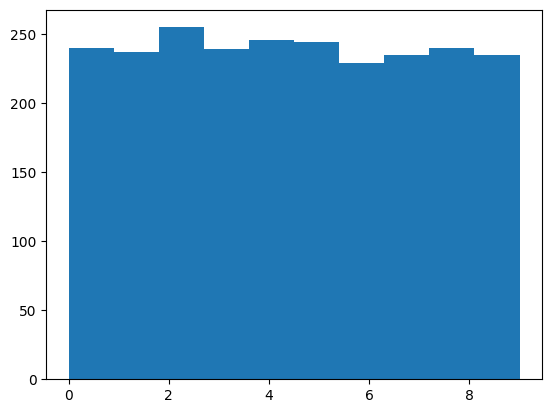

In [ ]:
train_labels = [label for wav, label in mnist_dataset_train]
plt.hist(train_labels)
plt.show()

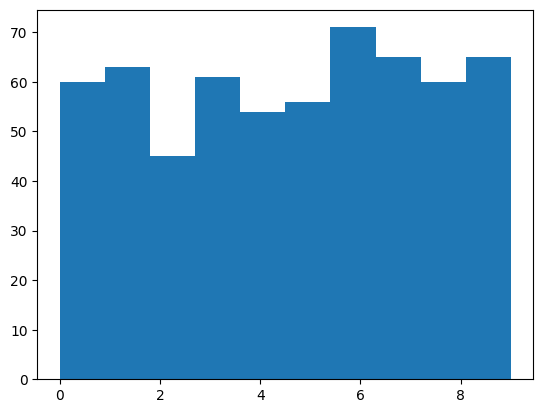

In [ ]:
val_labels = [label for wav, label in mnist_dataset_val]
plt.hist(val_labels)
plt.show()

In [ ]:
def collate_fn(batch):
    """wavs, srs, labels in batch"""
    labels = []
    lengths = []
    wavs = []

    for wave, label in batch:
        labels.append(label)
        lengths.append(wave.size(-1))
        wavs.append(wave)

    max_length = max(lengths)
    padded_wavs = torch.zeros(len(batch), max_length)

    for i in range(len(batch)):
        padded_wavs[i, :lengths[i]] = wavs[i]

    labels = torch.tensor(labels).long()
    lengths = torch.tensor(lengths)

    return {
        'wavs': padded_wavs,
        'labels': labels,
        'lengths': lengths
    }


In [ ]:
class FeatureRiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=8000,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            center=True
        )
    def forward(self, wav, length=None):
        mel_spec = self.featurizer(wav)
        mel_spec = mel_spec.clamp(min=1e-5).log()
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            length += 1 + 4
            return mel_spec, length
        return mel_spec

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_size, num_classes):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=num_classes)

    def forward(self, x, length=None):
        x, _ = self.lstm(x.transpose(-1, -2))
        x = torch.gather(
            x,
            dim=1,
            index=length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
        )
        logits = self.linear(x.squeeze(dim=1))
        return logits

In [ ]:
from torch.utils.data.dataloader import DataLoader
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Model(input_dim=64,
              hidden_size=128,
              num_classes=10).to(device)
featurizer = FeatureRiser().to(device)
train_loader = DataLoader(dataset=mnist_dataset_train,
                          batch_size=32, num_workers=2,
                          shuffle=True, pin_memory=True,
                          drop_last=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset=mnist_dataset_val,
                          batch_size=32, num_workers=2,
                          shuffle=False, pin_memory=True,
                          drop_last=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
EPOCHS = 7

In [ ]:
first_iter = next(iter(train_loader))
print(first_iter['wavs'].shape)
print(first_iter['lengths'].shape)
first_iter_after_featurizer = featurizer(wav=first_iter['wavs'], length=first_iter['lengths'])
print(first_iter_after_featurizer[0].shape)
print(first_iter_after_featurizer[1].shape)
model(x=first_iter_after_featurizer[0], length=first_iter_after_featurizer[1]).shape

torch.Size([32, 17567])
torch.Size([32])
torch.Size([32, 64, 69])
torch.Size([32])


torch.Size([32, 10])

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    model.train()
    train_loss = 0
    train_acc = 0
    for i, batch in enumerate(train_loader):
        wavs = batch['wavs'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        lengths = batch['lengths'].to(device, non_blocking=True)
        mels, lengths = featurizer(wav=wavs, length=lengths)
        logits = model(x=mels, length=lengths)
        loss = criterion(logits, labels)
        matches = (logits.argmax(dim=-1) == labels).float().mean()
        train_acc += matches / len(train_loader)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f'train_loss: {train_loss}, train_acc: {train_acc}')
    model.eval()
    val_loss = 0
    val_acc = 0
    for i, batch in enumerate(val_loader):
        wavs = batch['wavs'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)
        lengths = batch['lengths'].to(device, non_blocking=True)
        with torch.no_grad():
            mels, lengths = featurizer(wav=wavs, length=lengths)
            logits = model(x=mels, length=lengths)
            loss = criterion(logits, labels)
            val_loss += loss.item()/len(val_loader)
        matches = (logits.argmax(dim=-1) == labels).float().mean()
        val_acc += matches / len(val_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'val_loss: {val_loss}, val_acc: {val_acc}')

EPOCH: 0
train_loss: 1.5704074287414547, train_acc: 0.5420831441879272
val_loss: 0.7621601323286691, val_acc: 0.8229167461395264
EPOCH: 1
train_loss: 0.407773476243019, train_acc: 0.9349998831748962
val_loss: 0.27633432464467156, val_acc: 0.9392359256744385
EPOCH: 2
train_loss: 0.15870745892326035, train_acc: 0.9720830917358398
val_loss: 0.13399137763513458, val_acc: 0.9756943583488464
EPOCH: 3
train_loss: 0.08323249548673625, train_acc: 0.9899995923042297
val_loss: 0.11280884676509431, val_acc: 0.96875
EPOCH: 4
train_loss: 0.059346305752793954, train_acc: 0.9895829558372498
val_loss: 0.13941949771510231, val_acc: 0.9548611044883728
EPOCH: 5
train_loss: 0.04353996736307939, train_acc: 0.9924994707107544
val_loss: 0.05292704856644073, val_acc: 0.9861111640930176
EPOCH: 6
train_loss: 0.029738110589484383, train_acc: 0.9954161047935486
val_loss: 0.04284200289597114, val_acc: 0.9861112236976624


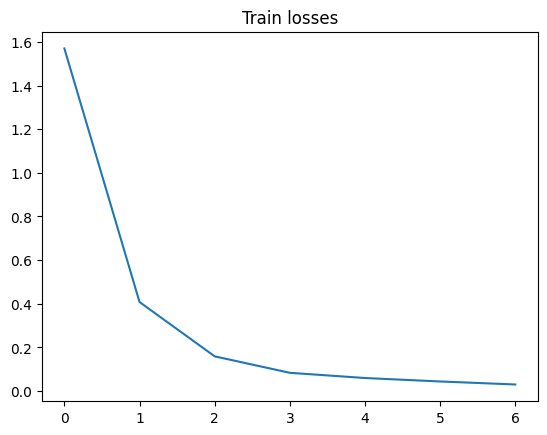

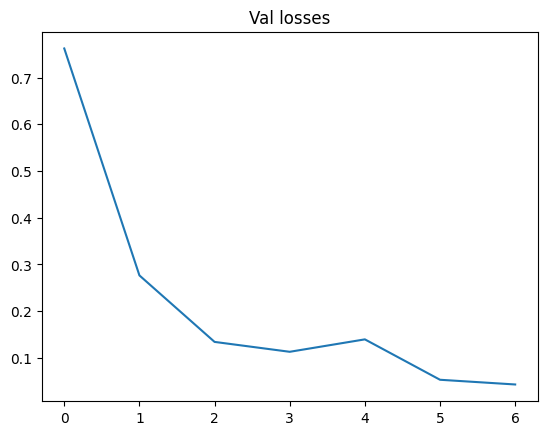

In [ ]:
plt.plot([x for x in range(EPOCHS)], train_losses)
plt.title('Train losses')
plt.show()
plt.plot([x for x in range(EPOCHS)], val_losses)
plt.title('Val losses')
plt.show()

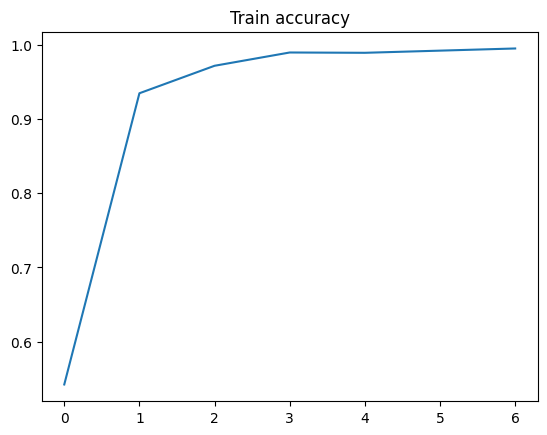

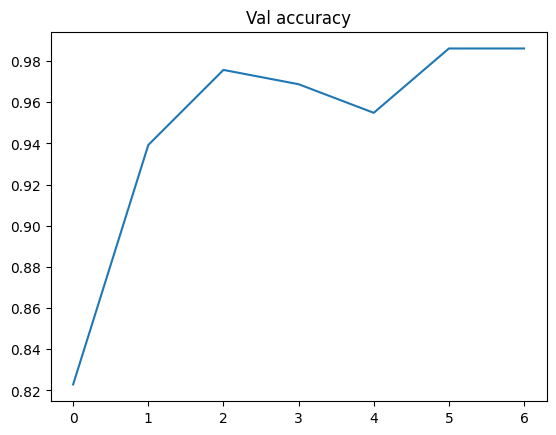

In [ ]:
plt.plot([x for x in range(EPOCHS)], [y.detach().cpu().item() for y in train_accs])
plt.title('Train accuracy')
plt.show()
plt.plot([x for x in range(EPOCHS)], [y.detach().cpu().item() for y in val_accs])
plt.title('Val accuracy')
plt.show()

In [ ]:
import torch

# Создаем исходный тензор
input = torch.tensor([[1, 2, 3],
                     [4, 5, 6],
                     [7, 8, 9]])

# Создаем тензор с индексами
index = torch.tensor([[0, 2, 1],
                     [2, 1, 0]])

# Извлекаем элементы из исходного тензора
output = torch.gather(input, dim=1, index=index)

print(output)

tensor([[1, 3, 2],
        [6, 5, 4]])
